Task 1

In [1]:
# Configs
from rdflib import Graph, Namespace, RDF, RDFS, OWL, Literal, XSD
from rdflib.namespace import FOAF
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_DIR = "data"
SCHEMA_FILE = os.path.join(OUTPUT_DIR, "schema.ttl")
BASE_URI = "http://kg-course.io/food-nutrition/"

RECIPES_CSV = os.path.join(DATA_DIR, "Recipes.csv")
NUTRITION_CSV = os.path.join(DATA_DIR, "Nutrition.csv")
RESTAURANTS_CSV = os.path.join(DATA_DIR, "Restaurants.csv")
REVIEWS_TXT = os.path.join(DATA_DIR, "Reviews.txt")

In [2]:
def create_schema():
    g = Graph()
    
    BASE = Namespace(BASE_URI)
    SCHEMA = Namespace("http://schema.org/")
    
    g.bind("", BASE)
    g.bind("schema", SCHEMA)
    g.bind("rdf", RDF)
    g.bind("rdfs", RDFS)
    g.bind("owl", OWL)
    g.bind("xsd", XSD)
    g.bind("foaf", FOAF)
    
    classes = [
        (BASE.Recipe, SCHEMA.Recipe, "Recipe"),
        (BASE.Nutrition, SCHEMA.NutritionInformation, "Nutrition"),
        (BASE.Restaurant, SCHEMA.Restaurant, "Restaurant"),
        (BASE.Review, SCHEMA.Review, "Review"),
        (BASE.Ingredient, SCHEMA.Ingredient, "Ingredient"),
        (BASE.Author, SCHEMA.Person, "Author"),
        (BASE.Cuisine, None, "Cuisine")
    ]
    
    for cls, schema_cls, label in classes:
        g.add((cls, RDF.type, RDFS.Class))
        g.add((cls, RDF.type, OWL.Class))
        g.add((cls, RDFS.label, Literal(label, lang="en")))
        if schema_cls:
            g.add((cls, RDFS.subClassOf, schema_cls))
    
    # For integration and SPARQL queries (connections)
    properties = [
        # Recipe
        (BASE.hasNutrition, BASE.Recipe, BASE.Nutrition),
        (BASE.hasReview, BASE.Recipe, BASE.Review),
        (BASE.hasCuisine, BASE.Recipe, BASE.Cuisine),
        (BASE.hasIngredient, BASE.Recipe, BASE.Ingredient),
        
        # Restaurant
        (BASE.servesCuisine, BASE.Restaurant, BASE.Cuisine),
        
        # Review
        (BASE.mentionsIngredient, BASE.Review, BASE.Ingredient),
    ]
    
    for prop, domain, range_cls in properties:
        g.add((prop, RDF.type, RDF.Property))
        g.add((prop, RDF.type, OWL.ObjectProperty))
        g.add((prop, RDFS.domain, domain))
        g.add((prop, RDFS.range, range_cls))
    
    # For attributes
    datatype_props = [
        (BASE.hasAggregateSentiment, BASE.Recipe, XSD.float),
        (BASE.hasSentimentScore, BASE.Review, XSD.float),
        (BASE.hasSentimentLabel, BASE.Review, XSD.string),
        (BASE.hasOnlineDelivery, BASE.Restaurant, XSD.boolean),
        (BASE.hasTableBooking, BASE.Restaurant, XSD.boolean),
        (BASE.averageCostForTwo, BASE.Restaurant, XSD.float),
    ]
    
    for prop, domain, range_type in datatype_props:
        g.add((prop, RDF.type, RDF.Property))
        g.add((prop, RDF.type, OWL.DatatypeProperty))
        g.add((prop, RDFS.domain, domain))
        g.add((prop, RDFS.range, range_type))
    
    return g

schema_graph = create_schema()
print(f"{len(schema_graph)} triples")


75 triples


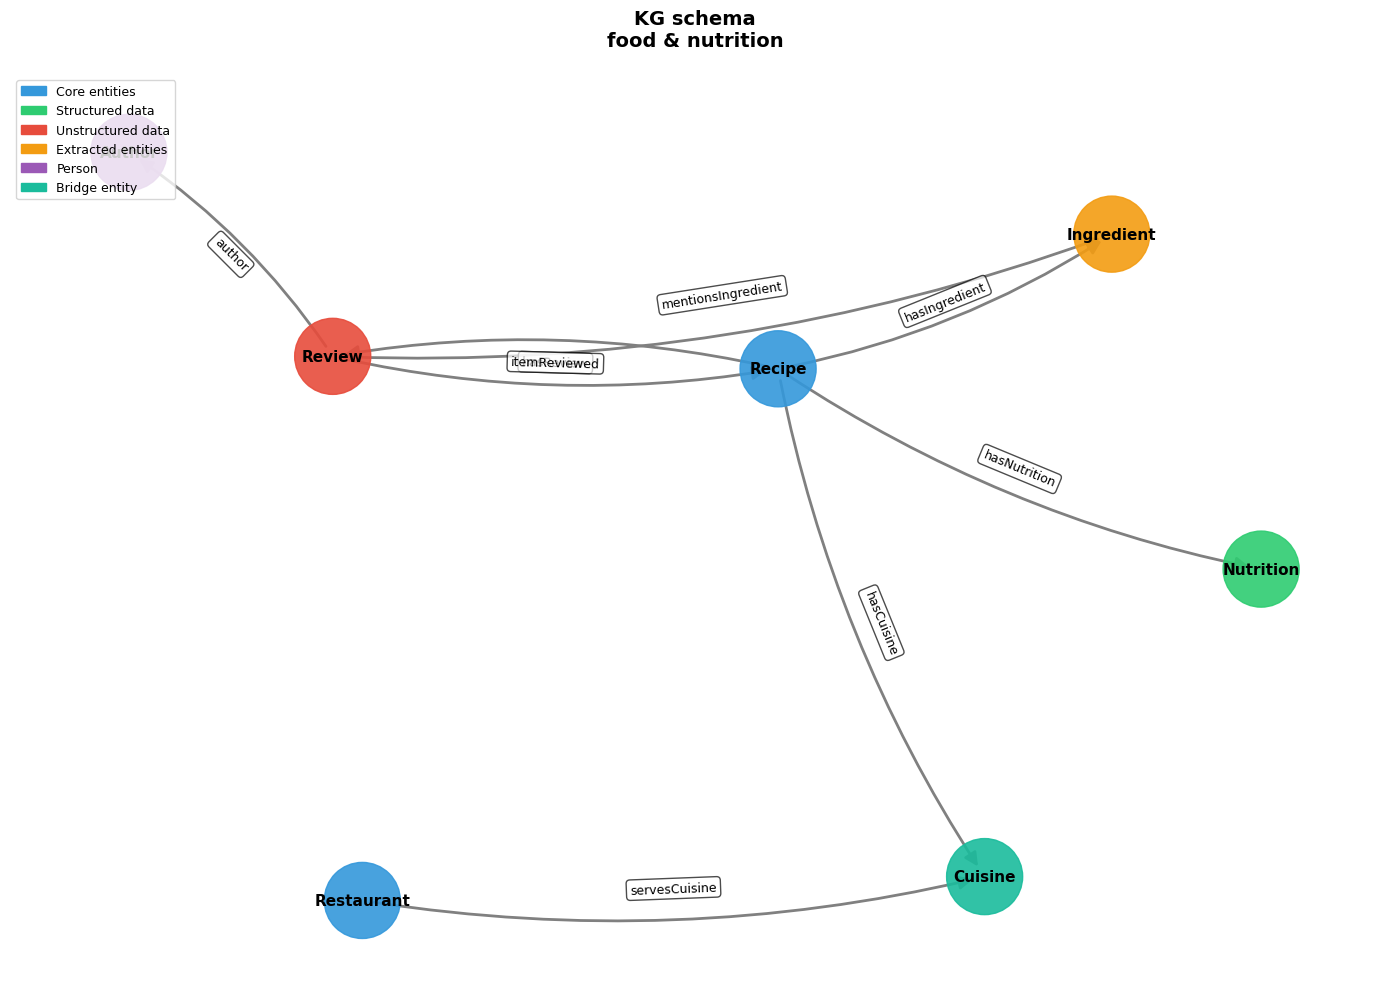

Diagram: outputs/schema_diagram.png


In [3]:
def create_diagram():
    G = nx.DiGraph()
    
    nodes = ['Recipe', 'Nutrition', 'Restaurant', 'Review', 'Ingredient', 'Author', 'Cuisine']
    G.add_nodes_from(nodes)
    
    edges = [ # With labels
        ('Recipe', 'Nutrition', 'hasNutrition'),
        ('Recipe', 'Review', 'hasReview'),
        ('Recipe', 'Cuisine', 'hasCuisine'),
        ('Recipe', 'Ingredient', 'hasIngredient'),
        ('Restaurant', 'Cuisine', 'servesCuisine'),
        ('Review', 'Recipe', 'itemReviewed'),
        ('Review', 'Author', 'author'),
        ('Review', 'Ingredient', 'mentionsIngredient'),
    ]
    
    for src, tgt, label in edges:
        G.add_edge(src, tgt, label=label)
    
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    colors = {
        'Recipe': '#3498db', 'Restaurant': '#3498db', # Core entities
        'Nutrition': '#2ecc71', # Structured data
        'Review': '#e74c3c', # Unstructured data
        'Ingredient': '#f39c12', # Extracted entities
        'Author': '#9b59b6', # Person
        'Cuisine': '#1abc9c' # Bridge entity
    }
    node_colors = [colors[n] for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                          arrowsize=20, width=2, connectionstyle='arc3,rad=0.1')
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9,
                                 bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', alpha=0.7))
    
    plt.title('KG schema\nfood & nutrition', 
             fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    legend = [
        mpatches.Patch(color='#3498db', label='Core entities'),
        mpatches.Patch(color='#2ecc71', label='Structured data'),
        mpatches.Patch(color='#e74c3c', label='Unstructured data'),
        mpatches.Patch(color='#f39c12', label='Extracted entities'),
        mpatches.Patch(color='#9b59b6', label='Person'),
        mpatches.Patch(color='#1abc9c', label='Bridge entity')
    ]
    plt.legend(handles=legend, loc='upper left', fontsize=9)
    
    plt.axis(False)
    plt.tight_layout()
    
    # Save
    diagram_file = os.path.join(OUTPUT_DIR, "schema_diagram.png")
    plt.savefig(diagram_file, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"Diagram: {diagram_file}")

create_diagram()

In [4]:
schema_graph.serialize(destination=SCHEMA_FILE, format="turtle")

print(f"Schema: {SCHEMA_FILE}")
print(f"Size: {os.path.getsize(SCHEMA_FILE)/1024:.1f} KB")
print(f"Triples: {len(schema_graph)}")

Schema: outputs/schema.ttl
Size: 2.4 KB
Triples: 75


In [5]:
# Display schema statistics
print("TASK 1")

classes = list(schema_graph.subjects(RDF.type, RDFS.Class))
properties = list(schema_graph.subjects(RDF.type, RDF.Property))

print(f"\nClasses: {len(classes)}")
for cls in classes:
    label = schema_graph.value(cls, RDFS.label)
    print(f"  - {label}")

print(f"\nProperties: {len(properties)}")

print("\nIntegration Points:")
print("Recipe <-> Restaurant via Cuisine")
print("Recipe <-> Nutrition (1:1 linking)")
print("Recipe <-> Review (sentiment)")
print("Ingredient <-> Wikidata (external KG)")

TASK 1

Classes: 7
  - Recipe
  - Nutrition
  - Restaurant
  - Review
  - Ingredient
  - Author
  - Cuisine

Properties: 12

Integration Points:
Recipe <-> Restaurant via Cuisine
Recipe <-> Nutrition (1:1 linking)
Recipe <-> Review (sentiment)
Ingredient <-> Wikidata (external KG)


Task 2

In [6]:
LIMIT = 10000

In [7]:
import pandas as pd
import hashlib
from rdflib import Graph, Namespace, RDF, Literal, XSD
import os

BASE = Namespace(BASE_URI)
SCHEMA = Namespace("http://schema.org/")

In [8]:
def clean(s):
    return "" if pd.isna(s) else str(s).strip()

def extract_cuisines(text):
    if not text:
        return []
    text = text.lower()
    cuisines = ['italian', 'chinese', 'indian', 'mexican', 'japanese', 'thai', 'french', 'greek', 'spanish', 'korean', 'vietnamese', 'american', 'mediterranean', 'asian', 'european']
    return [c for c in cuisines if c in text]

In [9]:
def load_csv_robust(filepath, nrows=None): # Because it failed a few times so I mad e a generic function
    
    # Comma delimiter
    try:
        df = pd.read_csv(filepath, nrows=nrows)
        if len(df.columns) > 1:
            return df
    except:
        pass
    
    # Semicolon delimiter
    try:
        df = pd.read_csv(filepath, nrows=nrows, sep=';')
        if len(df.columns) > 1:
            return df
    except:
        pass
    
    # Tab delimiter
    try:
        df = pd.read_csv(filepath, nrows=nrows, sep='\t')
        if len(df.columns) > 1:
            return df
    except:
        pass
    
    # Skip bad lines
    try:
        df = pd.read_csv(filepath, nrows=nrows, on_bad_lines='skip')
        if len(df.columns) > 1:
            return df
    except:
        pass
    
    # Python engine
    try:
        df = pd.read_csv(filepath, nrows=nrows, engine='python', on_bad_lines='skip')
        if len(df.columns) > 1:
            return df
    except:
        pass

# Load CSVs with robust method
recipes_df = load_csv_robust(RECIPES_CSV, nrows=LIMIT)
print(f"{len(recipes_df)} recipes")
nutrition_df = load_csv_robust(NUTRITION_CSV, nrows=LIMIT)
print(f"{len(nutrition_df)} nutrition records")
restaurants_df = load_csv_robust(RESTAURANTS_CSV, nrows=LIMIT)
print(f"{len(restaurants_df)} restaurants")

10000 recipes
10000 nutrition records
9550 restaurants


In [10]:
# Initialize graph with schema for converting to RDF
g = Graph()
g.parse(SCHEMA_FILE, format="turtle")

recipe_name_to_uri = {}
cuisine_uris = {}

print(f"{len(g)} triples from schema")

cuisine_uris = {}
cuisine_counter = 0

75 triples from schema


In [11]:
# Convert Recipes
def find_col(df, search_terms):
    
    if isinstance(search_terms, str):
        search_terms = [search_terms]
    
    for col in df.columns:
        for term in search_terms:
            if term.lower() in col.lower():
                return col
    
    # Return first column as fallback
    return df.columns[0]

cuisine_counter = 0
cuisine_name_to_uri = {}

for idx, row in recipes_df.iterrows():
    # print(idx) # debug
    # Create URI
    recipe_id = str(int(row['RecipeId'])) if pd.notna(row.get('RecipeId')) else f"r{idx}"
    recipe_uri = BASE[f"recipe_{idx}"]
    
    g.add((recipe_uri, RDF.type, BASE.Recipe)) # Add type
    
    # Add properties
    name = clean(row.get('Name'))
    if name:
        g.add((recipe_uri, SCHEMA.name, Literal(name)))
        recipe_name_to_uri[name] = recipe_uri
    
    if pd.notna(row.get('CookTime')):
        g.add((recipe_uri, SCHEMA.cookTime, Literal(str(row['CookTime']))))
    
    if pd.notna(row.get('PrepTime')):
        g.add((recipe_uri, SCHEMA.prepTime, Literal(str(row['PrepTime']))))
    
    if pd.notna(row.get('DatePublished')):
        g.add((recipe_uri, SCHEMA.datePublished, Literal(str(row['DatePublished']))))
    
    if pd.notna(row.get('RecipeCategory')):
        g.add((recipe_uri, SCHEMA.recipeCategory, Literal(clean(row['RecipeCategory']))))
    
    if pd.notna(row.get('Keywords')):
        g.add((recipe_uri, SCHEMA.keywords, Literal(clean(row['Keywords']))))
    
    if pd.notna(row.get('RecipeIngredientParts')):
        g.add((recipe_uri, SCHEMA.recipeIngredient, Literal(clean(row['RecipeIngredientParts']))))
    
    # Extract cuisines
    category = clean(row.get('RecipeCategory', '')) + ' ' + clean(row.get('Keywords', ''))
    for cuisine in extract_cuisines(category):
        if cuisine not in cuisine_uris:
            cuisine_uri = BASE[f"cuisine_{cuisine_counter}"]
            g.add((cuisine_uri, RDF.type, BASE.Cuisine))
            g.add((cuisine_uri, SCHEMA.name, Literal(cuisine)))
            cuisine_name_to_uri[cuisine] = cuisine_uri
            cuisine_counter += 1
        else:
            cuisine_uri = cuisine_name_to_uri[cuisine]
        
        g.add((recipe_uri, BASE.hasCuisine, cuisine_uri)) # Link recipe to cuisine

print(f"{len(recipes_df)} Recipes")
print(f"{len(g)} triples")

recipe_name_to_uri = {}
name_col = find_col(recipes_df, ['Name', 'name', 'RecipeName'])

for idx, row in recipes_df.iterrows():
    # print(idx) # debug
    recipe_uri = BASE[f"recipe_{idx}"]
    recipe_name = clean(str(row[name_col]))
    recipe_name_to_uri[recipe_name] = recipe_uri

# print(f"Built lookup for {len(recipe_name_to_uri)} recipe names")

10000 Recipes
85144 triples


In [12]:
# Convert nutrition and link to recipes

print("Nutrition cols:", nutrition_df.columns.tolist())

linked = 0
for idx, row in nutrition_df.iterrows():
    # Create URI
    name_col = [col for col in nutrition_df.columns if 'name' in col.lower()][0]
    name = clean(row[name_col])
    nutrition_id = hashlib.md5(name.encode()).hexdigest()[:12]
    nutrition_uri = BASE[f"nutrition_{idx}"]
    
    g.add((nutrition_uri, RDF.type, BASE.Nutrition))
    
    # Link to recipe
    recipe_uri = recipe_name_to_uri.get(name)
    if recipe_uri:
        g.add((recipe_uri, BASE.hasNutrition, nutrition_uri))
        linked += 1
    
    # Add nutritional values
    for field, predicate in [
        ('Calories', SCHEMA.calories),
        ('FatContent', SCHEMA.fatContent),
        ('SaturatedFatContent', SCHEMA.saturatedFatContent),
        ('CholesterolContent', SCHEMA.cholesterolContent),
        ('SodiumContent', SCHEMA.sodiumContent),
        ('CarbohydrateContent', SCHEMA.carbohydrateContent),
        ('FiberContent', SCHEMA.fiberContent),
        ('SugarContent', SCHEMA.sugarContent),
        ('ProteinContent', SCHEMA.proteinContent)
    ]:
        if pd.notna(row.get(field)):
            g.add((nutrition_uri, predicate, Literal(float(row[field]), datatype=XSD.float)))

print(f"Converted {len(nutrition_df)} nutrition records")
print(f"Linked {linked} to recipes")
print(f"Graph count: {len(g)} triples")

Nutrition cols: ['Name', 'Description', 'RecipeCategory', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
Converted 10000 nutrition records
Linked 10000 to recipes
Graph count: 195144 triples


In [13]:
# Convert Restaurants
print("Recipe columns:", recipes_df.columns.tolist())
print("Nutrition columns:", nutrition_df.columns.tolist())
print("Restaurant columns:", restaurants_df.columns.tolist())
def find_col(df, search_terms):
    if isinstance(search_terms, str):
        search_terms = [search_terms]
    
    for col in df.columns:
        for term in search_terms:
            if term.lower() in col.lower():
                return col
    return df.columns[0]

restaurants_df.columns = restaurants_df.columns.str.strip() # Normalize column names

rest_id_col = find_col(restaurants_df, ['Restaurant ID', 'ID', 'RestaurantID'])
name_col = find_col(restaurants_df, ['Restaurant Name', 'Name', 'RestaurantName'])
city_col = find_col(restaurants_df, ['City', 'Locality', 'Location'])
cuisines_col = find_col(restaurants_df, ['Cuisines', 'Cuisine'])
cost_col = find_col(restaurants_df, ['Average cost of two in USD', 'Average Cost for two', 'Average Cost for Two'])

# print("Names of cols:")
# print("  ID      :", rest_id_col)
# print("  Name    :", name_col)
# print("  City    :", city_col)
# print("  Cuisines:", cuisines_col)

for idx, row in restaurants_df.iterrows():
    rest_id = str(row.get(rest_id_col, idx))
    restaurant_uri = BASE[f"restaurant_{idx}"]

    g.add((restaurant_uri, RDF.type, BASE.Restaurant))

    # Name
    if pd.notna(row.get(name_col)):
        g.add((restaurant_uri, SCHEMA.name, Literal(clean(row.get(name_col)))))

    # Address
    if pd.notna(row.get('Address')):
        g.add((restaurant_uri, SCHEMA.address, Literal(clean(row.get('Address')))))

    # City using detected city column
    if pd.notna(row.get(city_col)):
        g.add((restaurant_uri, SCHEMA.addressLocality, Literal(clean(row.get(city_col)))))

    # Country
    if pd.notna(row.get('Country')):
        g.add((restaurant_uri, SCHEMA.addressCountry, Literal(clean(row.get('Country')))))

    # Geo coordinates
    if pd.notna(row.get('Latitude')) and pd.notna(row.get('Longitude')):
        lat, lon = float(row.get('Latitude')), float(row.get('Longitude'))
        if lat != 0 and lon != 0:
            geo_uri = BASE[f"geo_{idx}"]
            g.add((geo_uri, RDF.type, SCHEMA.GeoCoordinates))
            g.add((geo_uri, SCHEMA.latitude, Literal(lat, datatype=XSD.float)))
            g.add((geo_uri, SCHEMA.longitude, Literal(lon, datatype=XSD.float)))
            g.add((restaurant_uri, SCHEMA.geo, geo_uri))

    # Aggregate rating
    if pd.notna(row.get('Aggregate rating')):
        g.add((restaurant_uri, SCHEMA.aggregateRating,
                   Literal(float(row.get('Aggregate rating')), datatype=XSD.float)))

    # Cost
    if pd.notna(row.get(cost_col)):
        g.add((restaurant_uri, BASE.averageCostForTwo, Literal(float(row.get(cost_col)), datatype=XSD.float))) 

    # Booleans
    if pd.notna(row.get('Has Online delivery')):
        has_delivery = str(row.get('Has Online delivery')).strip().lower() in ['yes', 'true', '1']
        g.add((restaurant_uri, BASE.hasOnlineDelivery, Literal(has_delivery, datatype=XSD.boolean)))

    if pd.notna(row.get('Has Table booking')):
        has_booking = str(row.get('Has Table booking')).strip().lower() in ['yes', 'true', '1']
        g.add((restaurant_uri, BASE.hasTableBooking, Literal(has_booking, datatype=XSD.boolean)))

    # Cuisines using detected cuisines col
    cuisines_text = clean(row.get(cuisines_col, ''))
    for cuisine in extract_cuisines(cuisines_text):
        cuisine_uri = cuisine_uris.get(cuisine)
        if not cuisine_uri:
            cuisine_uri = BASE[f"cuisine_{cuisine_counter}"]
            g.add((cuisine_uri, RDF.type, BASE.Cuisine))
            g.add((cuisine_uri, SCHEMA.name, Literal(cuisine)))
            cuisine_uris[cuisine] = cuisine_uri
        g.add((restaurant_uri, BASE.servesCuisine, cuisine_uri))

print(f"Converted {len(restaurants_df)} restaurants")
print(f"Found {len(cuisine_uris)} unique cuisines")
print(f"Graph now: {len(g)} triples")

Recipe columns: ['RecipeId', 'Name', 'CookTime', 'PrepTime', 'DatePublished', 'Images', 'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeServings', 'RecipeYield', 'RecipeInstructions']
Nutrition columns: ['Name', 'Description', 'RecipeCategory', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']
Restaurant columns: ['Restaurant ID', 'Restaurant Name', 'Country', 'City', 'Address', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes', 'Nummber of dishes in cuisines', 'Average cost of two in USD']
Converted 9550 restaurants
Found 15 unique cuisines
Graph now: 323726 triples


## Save Knowledge Graph

In [14]:
output_file = os.path.join(OUTPUT_DIR, "KEN4256-structured-KG-team2.ttl")
g.serialize(destination=output_file, format="turtle")

file_size_mb = os.path.getsize(output_file) / (1024 * 1024)

print("Task 2:")
print(f"Output: {output_file}")
print(f"Size: {file_size_mb:.1f} MB")
print(f"Total triples: {len(g):,}")
print(f"Integration:")
print(f"Recipe <-> Nutrition: {linked}/{len(nutrition_df)} linked")
print(f"Recipe <-> Restaurant: via {len(cuisine_uris)} shared cuisines")

Task 2:
Output: outputs/KEN4256-structured-KG-team2.ttl
Size: 14.4 MB
Total triples: 323,726
Integration:
Recipe <-> Nutrition: 10000/10000 linked
Recipe <-> Restaurant: via 15 shared cuisines


Task3

In [15]:
STRUCTURED_KG = "outputs/KEN4256-structured-KG-team2.ttl"

REVIEW_LIMIT = 1000
WIKIDATA_RECIPE_LIMIT = 1000

In [16]:
!pip install spacy vaderSentiment SPARQLWrapper -q
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [17]:
import pandas as pd
import spacy
import hashlib
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, Namespace, RDF, RDFS, OWL, Literal, XSD, URIRef

BASE = Namespace(BASE_URI)
SCHEMA = Namespace("http://schema.org/")
WD = Namespace("http://www.wikidata.org/entity/")

# Load models
nlp = spacy.load("en_core_web_sm")
sentiment_analyzer = SentimentIntensityAnalyzer()

In [18]:
reviews = []
with open(REVIEWS_TXT, 'r', encoding='utf-8', errors='ignore') as f:
    for i, line in enumerate(f):
        if i >= REVIEW_LIMIT:
            break
        line = line.strip()
        if line:
            reviews.append(line)

print(f"{len(reviews)} reviews")

1000 reviews


In [19]:
def extract_ingredients(text):
    doc = nlp(text[:500]) # For speed
    ingredients = set()
    
    # Look for them
    for ent in doc.ents:
        if ent.label_ in ['PRODUCT', 'ORG']:
            ingredient = ent.text.lower().strip()
            if len(ingredient) > 2:
                ingredients.add(ingredient)
    
    #Check for common food nouns
    food_words = {'chicken', 'beef', 'pork', 'fish', 'rice', 'pasta', 'cheese', 'tomato', 'onion', 'garlic', 'pepper', 'salt', 'sugar', 'flour', 'egg', 'milk', 'butter', 'oil', 'bread', 'potato', 'carrot'}
    
    for token in doc:
        if token.text.lower() in food_words:
            ingredients.add(token.text.lower())
    return list(ingredients)

def analyze_sentiment(text):
    scores = sentiment_analyzer.polarity_scores(text)
    compound = scores['compound']
    
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    
    return compound, label, abs(compound)

In [20]:
review_data = []
all_ingredients = set()

for idx, text in enumerate(reviews):
    ingredients = extract_ingredients(text) # Extract
    all_ingredients.update(ingredients)
    
    score, label, confidence = analyze_sentiment(text) # Sentiment
    review_data.append({
        'id': idx,
        'text': text,
        'ingredients': ingredients,
        'sentiment_score': score,
        'sentiment_label': label,
        'confidence': confidence
    })

print(f"{len(review_data)} reviews")
print(f"{len(all_ingredients)} unique ingredients")

1000 reviews
113 unique ingredients


In [21]:
g_unstructured = Graph()
g_unstructured.parse(SCHEMA_FILE, format="turtle") # Schema

ingredient_uris = {} # Avoid duplicates
ingredient_counter = 0

for idx, review in enumerate(review_data):
    review_uri = BASE[f"review_{idx}"]
    
    g_unstructured.add((review_uri, RDF.type, BASE.Review))
    g_unstructured.add((review_uri, BASE.hasSentimentScore, 
                       Literal(review['sentiment_score'], datatype=XSD.float)))
    g_unstructured.add((review_uri, BASE.hasSentimentLabel, 
                       Literal(review['sentiment_label'], datatype=XSD.string)))
    g_unstructured.add((review_uri, BASE.hasConfidence, 
                       Literal(review['confidence'], datatype=XSD.float)))

    # Add ingredients
    for ingredient_name in review['ingredients']:
        # print(ingredient_name) # check
        if ingredient_name not in ingredient_uris:
            ingredient_uri = BASE[f"ingredient_{ingredient_counter}"]
            g_unstructured.add((ingredient_uri, RDF.type, BASE.Ingredient))
            g_unstructured.add((ingredient_uri, RDFS.label, Literal(ingredient_name)))
            ingredient_uris[ingredient_name] = ingredient_uri
            ingredient_counter += 1
        else:
            ingredient_uri = ingredient_uris[ingredient_name]
        
        g_unstructured.add((review_uri, BASE.mentionsIngredient, ingredient_uri)) ## Link review to ingredient
        
print(f" Unstructured KG: {len(g_unstructured)} triples")

 Unstructured KG: 4675 triples


In [22]:
# Query Wikidata for common ingredients
def get_wikidata_id(ingredient_name):
    
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setReturnFormat(JSON)
    query = f"""
    SELECT ?item WHERE {{
      ?item rdfs:label "{ingredient_name}"@en .
      ?item wdt:P31/wdt:P279* wd:Q2095 .  # instance of food
    }}
    LIMIT 1
    """
    
    try:
        sparql.setQuery(query)
        results = sparql.query().convert()
        if results['results']['bindings']:
            return results['results']['bindings'][0]['item']['value']
    except:
        pass # it might time out
    return None

# Link top 20 ingredients (else too many queries)
linked_count = 0
for ingredient_name in list(ingredient_uris.keys())[:20]:
    wikidata_uri = get_wikidata_id(ingredient_name)
    if wikidata_uri:
        ingredient_uri = ingredient_uris[ingredient_name]
        g_unstructured.add((ingredient_uri, OWL.sameAs, URIRef(wikidata_uri)))
        linked_count += 1

print(f"{linked_count} ingredients llinked")
print(f"Final unstructured KG has {len(g_unstructured)} triples")

3 ingredients llinked
Final unstructured KG has 4678 triples


In [23]:
# Save
unstructured_file = os.path.join(OUTPUT_DIR, "KEN4256-unstructured-KG-team2.ttl") # EDIT: to change to UNSTRUCTURED_KG = os.path.join(OUTPUT_DIR, "KEN4256-unstructured-KG-team2.ttl") ???
g_unstructured.serialize(destination=unstructured_file, format="turtle")
print(f"Saved to: {unstructured_file}")

# Create integrated KG (structured + unstructured)
g_integrated = Graph()
g_integrated.parse(STRUCTURED_KG, format="turtle")
g_integrated.parse(unstructured_file, format="turtle")

integrated_file = os.path.join(OUTPUT_DIR, "KEN4256-integrated-KG-team2.ttl")
g_integrated.serialize(destination=integrated_file, format="turtle")
print(f"Saved to {integrated_file}")

print(f"Unstructured KG: {len(g_unstructured):,} triples")
print(f"Integrated KG: {len(g_integrated):,} triples")
print("")
print("Stats:")
print(f"{len(review_data)} reviews")
print(f"{len(ingredient_uris)} unique ingredients")
print(f"{linked_count} Wikidata links")

Saved to: outputs/KEN4256-unstructured-KG-team2.ttl
Saved to outputs/KEN4256-integrated-KG-team2.ttl
Unstructured KG: 4,678 triples
Integrated KG: 328,329 triples

Stats:
1000 reviews
113 unique ingredients
3 Wikidata links


Task 4

In [24]:
INTEGRATED_KG = os.path.join(OUTPUT_DIR, "KEN4256-integrated-KG-team2.ttl") 
OUTPUT_DIR = "outputs"

In [25]:
from rdflib import Graph
import datetime

g = Graph()
g.parse(INTEGRATED_KG, format="turtle")
print(f"{len(g):,} triples")

def run_query(query, title): # Execute SPARQL query and return results
    results = g.query(query)
    print(f"\n{title}\n")
    
    result_list = []
    for row in results:
        result_list.append(row)
        print(" | ".join(str(val) for val in row))
    
    print(f"\n{len(result_list)} result(s)")
    return result_list, query

328,329 triples


In [26]:
query_1 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?recipeName
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            schema:recipeIngredient ?ingredients .
    
    FILTER(CONTAINS(LCASE(STR(?ingredients)), "mango"))
}
ORDER BY ?recipeName
LIMIT 20
"""

results_1, _ = run_query(query_1, "4.1: Recipes wigth mango")


4.1: Recipes wigth mango

Avocado-Mango Salsa
Banana and Mango Bread
Blackened Swordfish with Tropical Fruit Salsa
Chaat Masala
Charishma's Yummy Mango Halwa
Cherry Pecan Carrot Layer Cake
Chicken Curry
Chicken with Curried Mango Sauce
Chicken with Mango Salsa
Children's Mango Chaat
Citrus-Rubbed Veal Chops with Sunshine Salsa
Coconut Pork and Chilli Chutney
Di's Mango Mousse Trifle
Fresh Fruit Frappe
Fresh Salsa (A La Gringo)
Fruit Salsa
Fruited Spinach Salad With Honey Mustard Dressing
Green Mango Salad With Cilantro Vinaigrette
Hawaiian Fruit Dip
Honey-Cheddar-Chutney Scones

20 result(s)


In [27]:
query_2 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?recipeName ?cookTime ?keywords
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            schema:cookTime ?cookTime ;
            schema:keywords ?keywords .
    
    # Contains 'pie' AND 'healthy'
    FILTER(CONTAINS(LCASE(?recipeName), "pie") || CONTAINS(LCASE(?keywords), "pie"))
    FILTER(CONTAINS(LCASE(?keywords), "healthy"))
    
    FILTER( # Check for PT formats with hours < 2 or only minutes
        CONTAINS(?cookTime, "PT") && 
        (!CONTAINS(?cookTime, "H") || 
         CONTAINS(?cookTime, "PT0") || 
         CONTAINS(?cookTime, "PT1H"))
    )
}
ORDER BY ?recipeName
LIMIT 10
"""

results_2, _ = run_query(query_2, "4.2: Healthy pies < 2h cooktime")


4.2: Healthy pies < 2h cooktime

5-Ingredient Strawberry Pie | PT5M | c("Dessert", "Strawberry", "Berries", "Fruit", "Low Protein", "Low Cholesterol", "Healthy", "< 15 Mins", "Easy")
Apple Pie #3 | PT35M | c("Dessert", "Apple", "Fruit", "Low Protein", "Low Cholesterol", "Healthy", "< 60 Mins", "Oven", "Easy")
Apple Pie Filling | PT1H30M | c("Dessert", "Apple", "Fruit", "Low Protein", "Low Cholesterol", "Healthy", "Weeknight", "Canning", "< 4 Hours", "Easy")
Blackberry Pie | PT45M | c("Dessert", "Fruit", "Healthy", "< 60 Mins", "Oven")
Blue Mountain Blueberry Pie | PT45M | c("Dessert", "Berries", "Fruit", "Low Protein", "Low Cholesterol", "Healthy", "Weeknight", "Oven", "< 4 Hours")
Buttermilk Pie With Gingersnap Crumb Crust | PT50M | c("Dessert", "Healthy", "Weeknight", "Oven", "< 4 Hours")
Caramel Apple Pie With Crunchy Crumb Topping | PT55M | c("Dessert", "Apple", "Fruit", "Low Protein", "Healthy", "Oven", "< 4 Hours")
Cherry Pie | PT55M | c("Dessert", "Cherries", "Fruit", "Low Prot

In [28]:
query_3 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>

SELECT DISTINCT ?restaurantName ?address
WHERE {
    ?restaurant a :Restaurant ;
                schema:name ?restaurantName ;
                schema:addressLocality ?city ;
                :hasOnlineDelivery ?delivery ;
                :servesCuisine ?cuisine .
    
    ?cuisine schema:name ?cuisineName .
    
    OPTIONAL { ?restaurant schema:address ?address . }
    FILTER(LCASE(STR(?city)) = "new delhi")
    FILTER(CONTAINS(LCASE(STR(?cuisineName)), "chinese"))
    FILTER(?delivery = true)
}
ORDER BY ?restaurantName
LIMIT 20
"""

results_3, _ = run_query(query_3, "4.3: New Delhi chinese restaurants with delivery")


4.3: New Delhi chinese restaurants with delivery

#OFF Campus | 284, Opposite Sri Venkateshwara College, Satyaniketan, New Delhi
28 Capri Italy | 28-A, Defence Colony Market, Defence Colony, New Delhi
33 Food | J-1/13, Gupta Colony, Khirki Extension, Malviya Nagar, New Delhi
361 Restaurant & Banquet | 361, Kohat Enclave, Pitampura, New Delhi
4 Barrels Caf�� & Lounge | 3rd Floor, DE-82, Tagore Garden, New Delhi
4 on 44 Restaurant & Bar | 112, Aggarwal City Mall, Road 44, Near M2K Multiplex, Pitampura, New Delhi
AOWLS | Vasant Vihar, New Delhi
Aashirwad Restaurant | B-125, Mangal Bazar Road, Guru Nanak Pura, Laxmi Nagar, New Delhi
Above & Beyond | A 22-23, 1st Floor, Tagore Market, Kirti Nagar, New Delhi
Ada "e" Haandi's | Shop 2, Sector 12, R K Puram, New Delhi
Ada e Handi Restaurant | 141, South Moti Bagh Market, Moti Bagh, New Delhi
Ada'e Handi | 37/1, Old Rajinder Nagar, Rajinder Nagar, New Delhi
Adyar Ananda Bhavan | S-18, Main Market, Green Park, New Delhi
Aggarwal Sweet Corner | 

In [29]:
query_4 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>

SELECT (AVG(?cost) AS ?avgCost)
WHERE {
    ?restaurant a :Restaurant ;
                schema:addressLocality ?city ;
                :averageCostForTwo ?cost ;
                :servesCuisine ?cuisine .
    
    ?cuisine schema:name ?cuisineName .
    
    FILTER(CONTAINS(LCASE(STR(?city)), "davenport"))
    
    # Asian cuisines
    FILTER(
        CONTAINS(LCASE(STR(?cuisineName)), "indian") ||
        CONTAINS(LCASE(STR(?cuisineName)), "sushi") ||
        CONTAINS(LCASE(STR(?cuisineName)), "asian") ||
        CONTAINS(LCASE(STR(?cuisineName)), "chinese") ||
        CONTAINS(LCASE(STR(?cuisineName)), "thai")
    )
}
"""

results_4, _ = run_query(query_4, "4.4: avg cost Davenport (asian food)")


4.4: avg cost Davenport (asian food)

25.294117647058822

1 result(s)


In [30]:
query_5 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?recipeName ?calories ?image ?datePublished
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            schema:recipeCategory ?category ;
            schema:keywords ?keywords ;
            :hasNutrition ?nutrition .
    
    ?nutrition schema:calories ?calories .
    
    OPTIONAL { ?recipe schema:image ?image . }
    OPTIONAL { ?recipe schema:datePublished ?datePublished . }
    
    FILTER(CONTAINS(LCASE(?category), "dessert"))
    FILTER(CONTAINS(LCASE(?keywords), "easy"))
    FILTER(?calories < 300)
    
    # After 2000 (check dates)
    FILTER(
        !BOUND(?datePublished) ||
        (CONTAINS(STR(?datePublished), "200") ||
         CONTAINS(STR(?datePublished), "201") ||
         CONTAINS(STR(?datePublished), "202"))
    )
}
ORDER BY ?calories
LIMIT 5
"""

results_5, _ = run_query(query_5, "4.5: Top 5 easy desserts < 300 cal(after 2000)")


4.5: Top 5 easy desserts < 300 cal(after 2000)

frogs in the pond | 0.0 | None | 2001-09-10T09:16:00Z
Ice Cream Substitute | 0.0 | None | 2001-10-16T18:39:00Z
Julie's Chocolate Trifle | 10.5 | None | 2001-08-29T12:40:00Z
Pumpkin Fritters | 13.7 | None | 2001-08-24T16:52:00Z
Crystallized Flowers | 17.2 | None | 2001-03-14T11:27:00Z

5 result(s)


In [31]:
query_6 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>
SELECT ?recipeName ?avgSentiment ?prepTime ?sugar
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            schema:recipeCategory ?category ;
            :hasNutrition ?nutrition .
    OPTIONAL { ?recipe schema:prepTime ?prepTime . }
    OPTIONAL { ?nutrition schema:sugarContent ?sugar . }
    
    # Avg sentiment from reviews
    {
        SELECT ?recipe (AVG(?score) AS ?avgSentiment)
        WHERE {
            ?recipe :hasReview ?review .
            ?review :hasSentimentScore ?score .
        }
        GROUP BY ?recipe
    }
    
    FILTER(CONTAINS(LCASE(?category), "beverage") || CONTAINS(LCASE(?category), "drink")) # Category
}
ORDER BY DESC(?avgSentiment)
LIMIT 10
"""

results_6, _ = run_query(query_6, "4.6: Top 10 highly rated beverages")


4.6: Top 10 highly rated beverages

Cucumber Lemonade | None | PT5M | 33.2
Zesty Punch Sipper | None | PT10M | 12.6
Pineapple Freeze | None | PT0S | 43.6
Spice Party Punch | None | PT0S | 1041.8
Summer Citrus Punch | None | PT10M | 21.7
Hard Apple Cider | None | PT0S | 72.8
Chai Tea | None | PT15M | 0.0
Cafe Cappuccino | None | PT5M | 11.8
Homemade Bailey's Irish Cream Liqueur | None | PT5M | 14.8
Lemon Sherbet Punch | None | PT10M | 4.4

10 result(s)


In [32]:
query_7 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>

SELECT ?recipeName ?protein ?avgSentiment ?cuisineName ?usaCount
       (IF(?usaCount >= 5, true, false) AS ?cuisineCommonInUSA)
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            :hasNutrition ?nutrition ;
            :hasCuisine ?cuisine .

    ?nutrition schema:proteinContent ?protein .
    FILTER(?protein > 20)

    ?cuisine schema:name ?cuisineName .

    #"Highest-rated" recipes = average sentiment from reviews
    {
        SELECT ?recipe (AVG(?score) AS ?avgSentiment)
        WHERE {
            ?recipe :hasReview ?review .
            ?review :hasSentimentScore ?score .
        }
        GROUP BY ?recipe
    }


    BIND(COALESCE(?usaRestaurantCount, 0) AS ?usaCount)
}
ORDER BY DESC(?avgSentiment) DESC(?protein)
LIMIT 10
"""

results_7, _ = run_query(query_7, "4.7: Highest-rated protein-rich recipes + cuisine availability in USA")


4.7: Highest-rated protein-rich recipes + cuisine availability in USA

Veloute (used for "Lobster enchiladas w/white wine sauce") | 735.1 | None | european | 0 | false
Bayrischer Leberkaese | 597.8 | None | european | 0 | false
Coronation Chicken II | 518.6 | None | european | 0 | false
Steak and Kidney Pie V | 458.4 | None | european | 0 | false
Our Lasagna | 448.7 | None | european | 0 | false
Italian Sausage (Sweet or Hot) | 428.0 | None | european | 0 | false
Italian Sausage Sweet #2 | 425.7 | None | european | 0 | false
Vegetable Lasagna III | 388.0 | None | european | 0 | false
Seven Layer Mexican Salad | 328.5 | None | mexican | 0 | false
Artichoke and Red Pepper Pizza | 322.8 | None | european | 0 | false

10 result(s)


In [33]:
query_8 = """
PREFIX : <http://kg-course.io/food-nutrition/>
PREFIX schema: <http://schema.org/>
SELECT ?recipeName ?nds ?avgSentiment ?restaurantRating ?cuisineName
WHERE {
    ?recipe a :Recipe ;
            schema:name ?recipeName ;
            :hasNutrition ?nutrition ;
            :hasCuisine ?cuisine .
    
    ?nutrition schema:proteinContent ?protein ;
               schema:fiberContent ?fiber ;
               schema:sugarContent ?sugar .
    
    ?cuisine schema:name ?cuisineName .
    
    # Calculate NDS: (1.0 × Protein) + (1.5 × Fiber) − (2.0 × Sugar)
    BIND((1.0 * ?protein) + (1.5 * ?fiber) - (2.0 * ?sugar) AS ?nds)
    # Avg sentiment from reviews
    OPTIONAL {
        {
            SELECT ?recipe (AVG(?score) AS ?avgSentiment)
            WHERE {
                ?recipe :hasReview ?review .
                ?review :hasSentimentScore ?score .
            }
            GROUP BY ?recipe
        }
    }
    FILTER(?nds > 0)
}
ORDER BY DESC(?nds)
LIMIT 5
"""

results_8, _ = run_query(query_8, "4.8: Top 5 healthiest recipes by NDS")


4.8: Top 5 healthiest recipes by NDS

Veloute (used for "Lobster enchiladas w/white wine sauce") | 734.5 | None | None | european
Bayrischer Leberkaese | 590.8 | None | None | european
Coronation Chicken II | 509.65000000000003 | None | None | european
Italian Sausage (Sweet or Hot) | 432.90000000000003 | None | None | european
Our Lasagna | 418.79999999999995 | None | None | european

5 result(s)


In [34]:
# Collate
all_queries = [
    ("4.1", query_1, results_1),
    ("4.2", query_2, results_2),
    ("4.3", query_3, results_3),
    ("4.4", query_4, results_4),
    ("4.5", query_5, results_5),
    ("4.6", query_6, results_6),
    ("4.7", query_7, results_7),
    ("4.8",  query_8, results_8),
]

output_file = os.path.join(OUTPUT_DIR, "SPARQL_query_results.txt")
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("Task 4:\n")
    
    for num, query, results in all_queries:
        f.write(f"\nQuery {num}\n")
        
        f.write("\nSPARQL Query:\n")
        f.write(query.strip() + "\n\n")
        
        f.write("\nResults:\n")        
        if results:
            for i, row in enumerate(results, 1):
                f.write(f"{i}. " + " | ".join(str(val) for val in row) + "\n")
            f.write(f"\nTOTAL: {len(results)} result(s)\n")
        else:
            f.write("No results found.\n")
        
        f.write("\n")

# for individual files
for num, query, results in all_queries:
    per_query_file = os.path.join(OUTPUT_DIR, f"query_{num.replace('.', '_')}.txt")
    with open(per_query_file, 'w', encoding='utf-8') as f:
        f.write("Task 4:\n")
        f.write(f"\nQuery {num}\n")
        
        f.write("\nSPARQL Query:\n")
        f.write(query.strip() + "\n\n")
        
        f.write("\nResults:\n")
        if results:
            for i, row in enumerate(results, 1):
                f.write(f"{i}. " + " | ".join(str(val) for val in row) + "\n")
            f.write(f"\nTOTAL: {len(results)} result(s)\n")
        else:
            f.write("No results found.\n")
        
        f.write("\n")

print(f"Task 4 - combined results saved toL {output_file}")
print(f"\nNo. of results for each query:")
for num, _, results in all_queries:
    print(f"Query #{num}: {len(results)}")

Task 4 - combined results saved toL outputs/SPARQL_query_results.txt

No. of results for each query:
Query #4.1: 20
Query #4.2: 10
Query #4.3: 20
Query #4.4: 1
Query #4.5: 5
Query #4.6: 10
Query #4.7: 10
Query #4.8: 5
